In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Reshape, Conv2D, Conv2DTranspose, BatchNormalization, LeakyReLU, Dropout, Flatten
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from keras.utils import plot_model
import time

### a. Get a data

In [2]:
# Load the Fashion MNIST dataset
(ds1_hyeri_images, ds1_hyeri_labels), (ds2_hyeri_images, ds2_hyeri_labels) = tf.keras.datasets.fashion_mnist.load_data()

4422102/4422102 [==============================] - 1s 0us/step


### b. Pre-processing

In [3]:
# Normalize pixel values to range between -1 and 1
max_pixel_value = max(ds1_hyeri_images.max(), ds2_hyeri_images.max())
scaling_factor = max_pixel_value / 2 # Calculate the scaling factor

ds1_hyeri_images = (ds1_hyeri_images / scaling_factor) - 1.0
ds2_hyeri_images = (ds2_hyeri_images / scaling_factor) - 1.0

# Store the datasets into dictionaries
ds1_hyeri = {'images': ds1_hyeri_images, 'labels': ds1_hyeri_labels}
ds2_hyeri = {'images': ds2_hyeri_images, 'labels': ds2_hyeri_labels}

# Display the shape of the images datasets
print("Shape of ds1_hyeri['images']: ", ds1_hyeri_images.shape)
print("Shape of ds2_hyeri['images']: ", ds2_hyeri_images.shape)

# Concatenate the datasets
dataset_hyeri = np.concatenate((ds1_hyeri_images, ds2_hyeri_images), axis=0)

# Display the shape of the concatenated dataset
print("Shape of dataset_hyeri: ", dataset_hyeri.shape)

Shape of ds1_hyeri['images']:  (60000, 28, 28)
Shape of ds2_hyeri['images']:  (10000, 28, 28)
Shape of dataset_hyeri:  (70000, 28, 28)


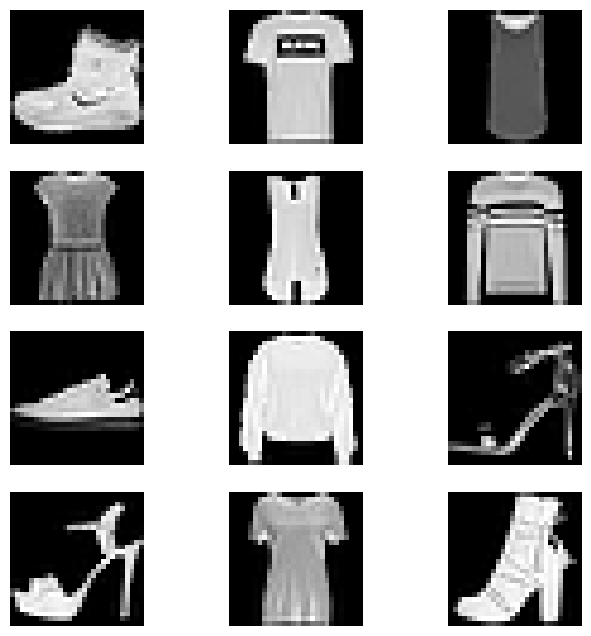

In [4]:
# Plot the first 12 images from the dataset
plt.figure(figsize=(8, 8))
for i in range(12):
    plt.subplot(4, 3, i+1)
    plt.imshow(dataset_hyeri[i], cmap='gray')
    plt.axis('off')
plt.show()

# Create TensorFlow Dataset and batch it
train_dataset_hyeri = tf.data.Dataset.from_tensor_slices(dataset_hyeri)
train_dataset_hyeri = train_dataset_hyeri.shuffle(7000).batch(256)

### c. Build the Generator Model of the GAN

In [5]:
# Define the generator model
generator_model_hyeri = Sequential([
    Dense(7*7*256, use_bias=False, input_shape=(100,)),
    BatchNormalization(),
    LeakyReLU(),
    Reshape((7, 7, 256)),
    Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False),
    BatchNormalization(),
    LeakyReLU(),
    Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False),
    BatchNormalization(),
    LeakyReLU(),
    Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh')
])

In [6]:
# Display the summary of the generator model
generator_model_hyeri.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12544)             1254400   
                                                                 
 batch_normalization (Batch  (None, 12544)             50176     
 Normalization)                                                  
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 12544)             0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTr  (None, 7, 7, 128)         819200    
 anspose)                                                        
                                                                 
 batch_normalization_1 (Bat  (None, 7, 7, 128)         5

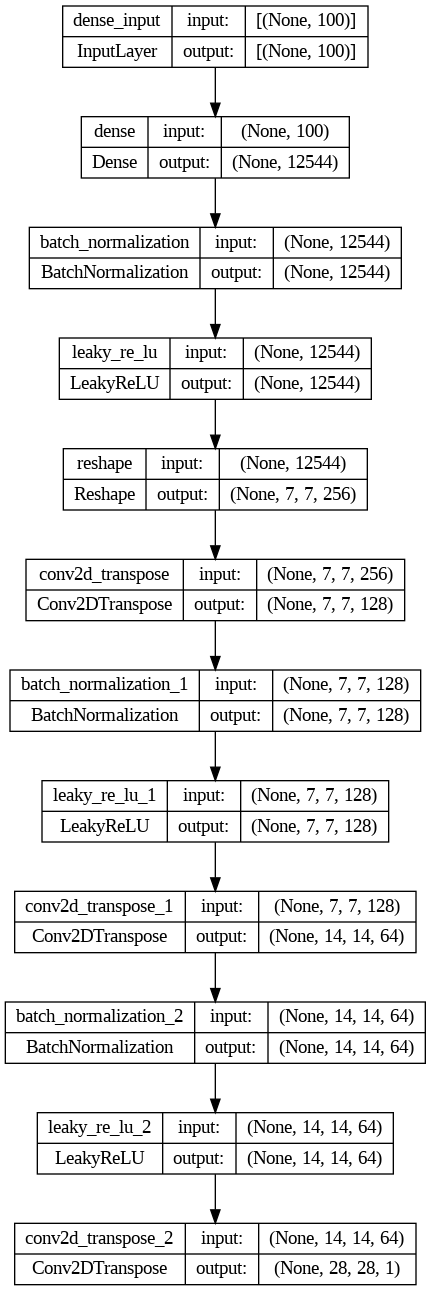

In [7]:
# Draw the diagram for the summary
plot_model(generator_model_hyeri, show_shapes=True, show_layer_names=True)

### d. Sample untrained generator

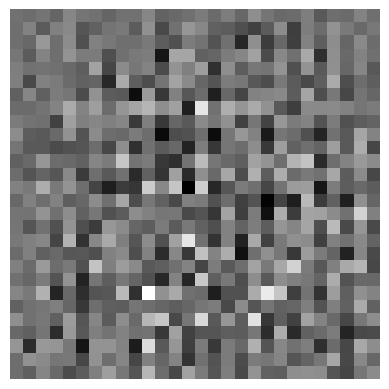

In [8]:
# Generate a sample vector
sample_vector = tf.random.normal([1, 100])

# Generate an image from the untrained generator
generated_image = generator_model_hyeri(sample_vector, training=False)

# Plot the generated image
plt.imshow(generated_image[0, :, :, 0], cmap='gray')
plt.axis('off')
plt.show()

### e. Build the Discriminator Model of the GAN

In [9]:
# Define the discriminator model
discriminator_model_hyeri = Sequential([
    Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]),
    LeakyReLU(),
    Dropout(0.3),
    Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
    LeakyReLU(),
    Dropout(0.3),
    Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same'),
    BatchNormalization(),
    LeakyReLU(),
    Flatten(),
    Dense(1)
])

In [10]:
# Display the summary of the discriminator model
discriminator_model_hyeri.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 conv2d_transpose_3 (Conv2D  (None, 14, 14, 64)       

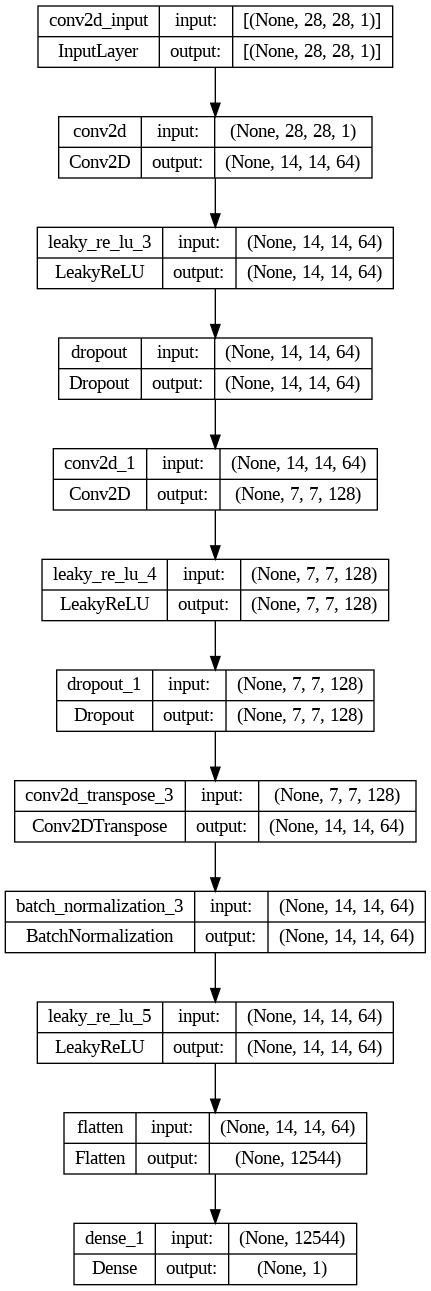

In [11]:
# Draw the diagram for the summary
plot_model(discriminator_model_hyeri, show_shapes=True, show_layer_names=True)

### f. Implement Training

In [12]:
# Define loss function
cross_entropy_hyeri = BinaryCrossentropy(from_logits=True)

# Define optimizers
generator_optimizer_hyeri = Adam(1e-4)
discriminator_optimizer_hyeri = Adam(1e-4)

# Define training step function
@tf.function
def train_step(images):
    noise = tf.random.normal([256, 100])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator_model_hyeri(noise, training=True)

        real_output = discriminator_model_hyeri(images, training=True)
        fake_output = discriminator_model_hyeri(generated_images, training=True)

        gen_loss = cross_entropy_hyeri(tf.ones_like(fake_output), fake_output)
        real_loss = cross_entropy_hyeri(tf.ones_like(real_output), real_output)
        fake_loss = cross_entropy_hyeri(tf.zeros_like(fake_output), fake_output)
        disc_loss = real_loss + fake_loss
    gradients_of_generator = gen_tape.gradient(gen_loss, generator_model_hyeri.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator_model_hyeri.trainable_variables)
    generator_optimizer_hyeri.apply_gradients(zip(gradients_of_generator, generator_model_hyeri.trainable_variables))
    discriminator_optimizer_hyeri.apply_gradients(zip(gradients_of_discriminator, discriminator_model_hyeri.trainable_variables))


### g. Train the model in batches with 10 epochs

In [13]:
# Train the models
num_epochs = 10
for epoch in range(num_epochs):
    start_time = time.time()
    for images_batch in train_dataset_hyeri:
        train_step(images_batch)
    epoch_time = time.time() - start_time
    print(f"Epoch {epoch + 1} took {epoch_time:.2f} seconds")

Epoch 1 took 29.42 seconds
Epoch 2 took 17.26 seconds
Epoch 3 took 17.73 seconds
Epoch 4 took 18.15 seconds
Epoch 5 took 18.38 seconds
Epoch 6 took 18.09 seconds
Epoch 7 took 17.97 seconds
Epoch 8 took 17.99 seconds
Epoch 9 took 18.10 seconds
Epoch 10 took 18.13 seconds


In [14]:
# Calculate and display how long it would take to train the same model using 70,000 training samples on 100 epochs
total_samples = 70000
total_epochs = 100
estimated_total_time = (total_samples / 256) * total_epochs * epoch_time
print(f"Estimated total training time for 70,000 samples on 100 epochs: {estimated_total_time:.2f} seconds")

Estimated total training time for 70,000 samples on 100 epochs: 495845.93 seconds


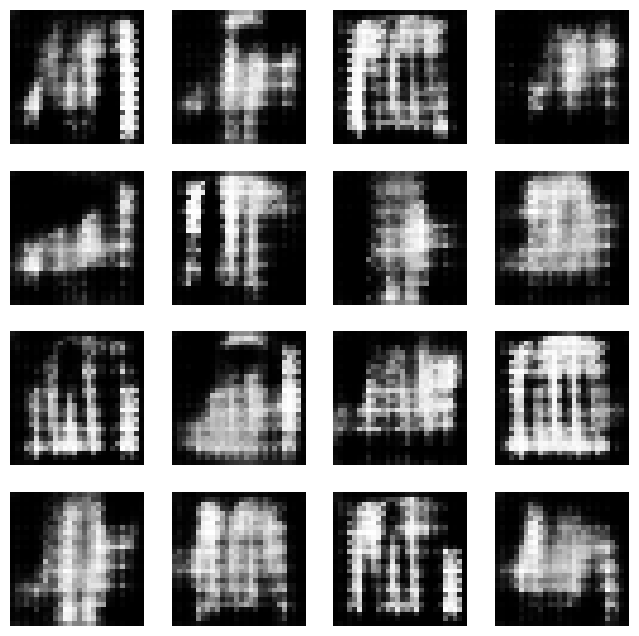

In [15]:
# Generate 16 sample vectors
sample_vectors = tf.random.normal([16, 100])

# Generate images from generator_model_firstname
generated_images = generator_model_hyeri(sample_vectors, training=False)

# Denormalize the pixel values
generated_images = 127.5 * generated_images + 127.5

# Plot generated images
plt.figure(figsize=(8, 8))
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(generated_images[i, :, :, 0], cmap='gray')
    plt.axis('off')
plt.show()